# import package

In [18]:
# Import Package
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import os
import random
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.feature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.colors as colors
import cartopy.feature as cfeature
from scipy.stats import norm
from scipy.stats import laplace
import matplotlib as mpl
from scipy import stats
import os
from scipy import optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import contextily as ctx
import xarray as xr

# Location of studied cities

(465, 2)


ConnectTimeout: HTTPSConnectionPool(host='a.basemaps.cartocdn.com', port=443): Max retries exceeded with url: /light_nolabels/1/0/0.png (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000023EDB5A2B10>, 'Connection to a.basemaps.cartocdn.com timed out. (connect timeout=None)'))

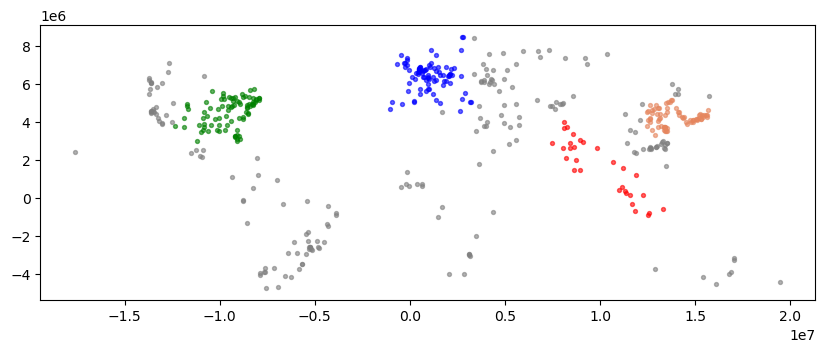

In [19]:
# process data into proper data frame

# spatial location
loc = np.loadtxt(r"loc.txt")
df_loc = pd.DataFrame(loc, columns=["lon", "lat"])

print(df_loc.shape)
def classify_location(row):
    lon, lat = row["lon"], row["lat"]
    if -111 <= lon <= -59 and 24 <= lat <= 48:
        return "ENA"
    elif -30 <= lon <= 30 and 38 <= lat <= 65:
        return "WE"
    elif 60 <= lon <= 90 and -10 <= lat <= 35:
        return "SA & SEA"
    elif 90 <= lon <= 120 and -20 <= lat <= 20:
        return "SA & SEA"
    elif 111 <= lon <= 142 and 28 <= lat <= 43:
        return "EA"
    else:
        return "Other"
df_loc["category"] = df_loc.apply(classify_location,axis=1)
category_colors = {
    "ENA": (69/255,42/255,61/255),
    "WE": (68/255,117/255,122/255),
    "SA & SEA": (212/255,76/255,60/255),
    "EA": (229/255,133/255,93/255),
    "Other": "grey"
}
category_colors = {
    "ENA": "g",
    "WE": "b",
    "SA & SEA": "r",
    "EA": (229/255,133/255,93/255),
    "Other": "grey"
}

# convert this into geoseries
gdf_loc = gpd.GeoDataFrame(
    df_loc,
    geometry=gpd.points_from_xy(df_loc.lon, df_loc.lat),
    crs="EPSG:4326"
).to_crs(epsg=3857)
w, s, e, n = gdf_loc.total_bounds
# w, s, e, n

def spatial_show_category(ax):
    for category, color in category_colors.items():
        gdf_loc[gdf_loc["category"] == category].plot(
            ax=ax,
            markersize=8,
            color=color,
            alpha=0.6,
            label=category
        )
    ctx.add_basemap(
        ax=ax,
        attribution="",
        source=ctx.providers.CartoDB.PositronNoLabels,
    )

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.autoscale(axis='x')
    ax.legend(loc = r"lower left",fontsize = 10)
    return ax
fig, ax = plt.subplots(figsize=(10, 10))
spatial_show_category(ax)



# spatial pattern of DI

ConnectTimeout: HTTPSConnectionPool(host='a.basemaps.cartocdn.com', port=443): Max retries exceeded with url: /light_nolabels/1/0/0.png (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000023ED9565010>, 'Connection to a.basemaps.cartocdn.com timed out. (connect timeout=None)'))

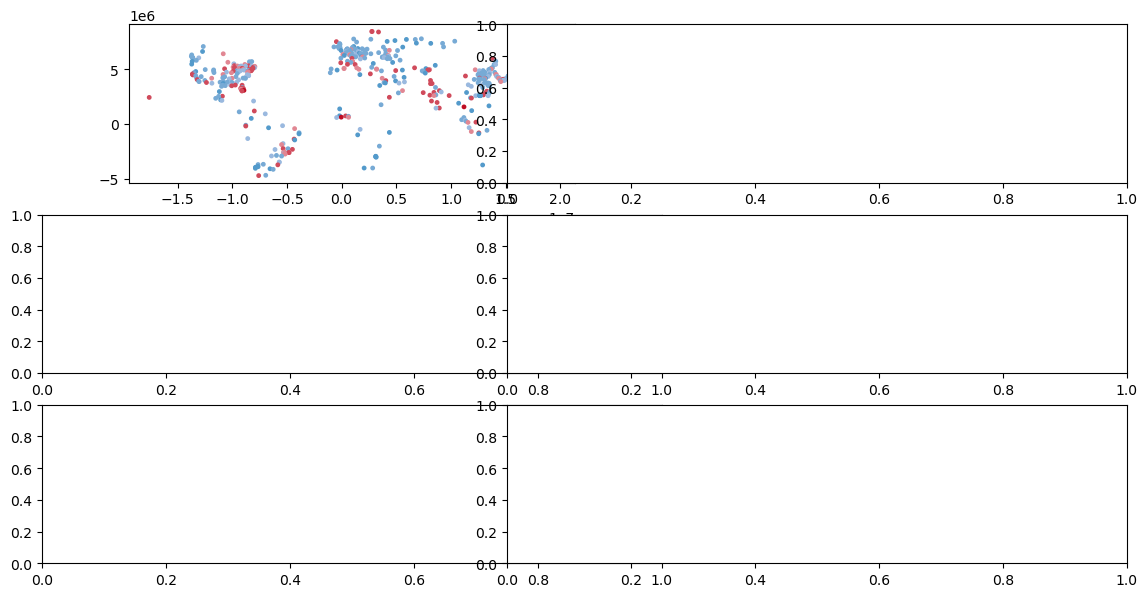

In [20]:
def blend_colors(color1, color2, blend_factor):
    """
    Blend two colors together.

    Parameters:
    - color1: The first color in RGB tuple format (e.g., (1, 0, 0) for red).
    - color2: The second color in RGB tuple format (e.g., (0, 0, 1) for blue).
    - blend_factor: A float between 0 and 1 that determines the blend proportion.

    Returns:
    - Blended color in RGB tuple format.
    """
    return tuple(
        (
            (1 - blend_factor) * np.array(color1) + blend_factor * np.array(color2)
        ).tolist()
    )


# time series of difference index
# 1. annual frequency of precipitation days of different intensity
import numpy as np
to5 = np.loadtxt(r"DI_data/result_1-5.txt")
to10 = np.loadtxt(r"DI_data/result_5-10.txt")
to20 = np.loadtxt(r"DI_data/result_10-20.txt")
over20 = np.loadtxt(r"DI_data/result_wet_day20.txt")

# 2. maximum precipitation of different time scale
daymax = np.loadtxt(r"DI_data/result_daymax1.txt")
hourmax = np.loadtxt(r"DI_data/result_hourmax.txt")

# process data in arrays into proper data frame
dict_ar_di = {
    "1 to 5mm": to5,
    "5 to 10mm": to10,
    "10 to 20mm": to20,
    "> 20mm": over20,
    "RX1day": daymax,
    "RX30min": hourmax,
}

# create data frame
dict_df_di = {}
# idx_loc = pd.Index(loc, name = "coords")
for key in dict_ar_di:
    dict_df_di[key] = pd.DataFrame(
        dict_ar_di[key],
        columns=pd.DatetimeIndex(
            pd.date_range("2001-1-1", "2021-1-1", freq="YE"),
            name="year",
        ),
    )
# pack all data frame into one
df_di = pd.concat(dict_df_di, axis=1,names=["di","year"])
df_di.index.rename("city", inplace=True)

# Define two colours in RGB format
color5 = (83 / 255, 154 / 255, 203 / 255)
color4 = (154 / 255, 185 / 255, 223 / 255)
color2 = (225 / 255, 135 / 255, 147 / 255)
color1 = (190 / 255, 13 / 255, 35 / 255)
blend_factors = np.linspace(0, 1, 3)
color_list =  [blend_colors(color1, color2, bf) for bf in blend_factors] + [blend_colors(color4, color5, bf) for bf in blend_factors] 

# spatial analysis of difference index
df_di_sel = (
    df_di.stack("di", future_stack=True)
    .median(axis=1)
    .unstack("di")
    .assign(geometry=gpd.points_from_xy(df_loc.lon, df_loc.lat),))
# construct a geodataframe
gdf_di_sel = gpd.GeoDataFrame(
    df_di_sel,
    geometry="geometry",
    crs="EPSG:4326"
).to_crs(epsg=3857)
index_name = ["1 to 5mm","5 to 10mm","10 to 20mm","> 20mm","RX1day","RX30min"]
title_name = ["A. 1 to 5mm","B. 5 to 10mm","C. 10 to 20mm","D. > 20mm","E. RX1day","F. RX30min"]

intervals = [-9999, -0.1, -0.02,0,0.02, 0.1, 9999]

def map_intervals_to_colors(series, intervals, colorlist):
    return pd.cut(series, bins=intervals, labels=colorlist, include_lowest=True)

color_df = gdf_di_sel.iloc[:, :-1].apply(map_intervals_to_colors, intervals=intervals, colorlist=color_list)
color_df = (
    color_df
    .assign(geometry=gpd.points_from_xy(df_loc.lon, df_loc.lat),))
color_df = gpd.GeoDataFrame(
    color_df,
    geometry="geometry",
    crs="EPSG:4326"
).to_crs(epsg=3857)
def plot_map(ax,data = color_df["1 to 5mm"]):
    color_df.plot(
        ax=ax,
        markersize=6,
        color=data)
    ctx.add_basemap(
        ax=ax,
        attribution="",
        source=ctx.providers.CartoDB.PositronNoLabels,
        # source=ctx.providers.CartoDB.DarkMatterNoLabels,
        # source=ctx.providers.Esri.WorldTopoMap,
        # source="https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}"
    )
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.autoscale(axis="x")
    return ax

index_name = ["1 to 5mm","5 to 10mm","10 to 20mm","> 20mm","RX1day","RX30min"]
title_name = ["(a) 1 to 5 mm","(b) 5 to 10 mm","(c) 10 to 20 mm","(d) > 20 mm","(e) RX1day","(f) RX30min"]

fig, axes = plt.subplots(
    3,
    2,
    figsize=(14,7),
)

fig.subplots_adjust(wspace=-0.25, hspace=0.2)
ax1,ax2,ax3,ax4,ax5,ax6 = axes[0,0],axes[0,1],axes[1,0],axes[1,1],axes[2,0],axes[2,1]
axlist = [ax1,ax2,ax3,ax4,ax5,ax6]
for i in range(6):
    axlist[i] = plot_map(axlist[i],color_df[index_name[i]])
    axlist[i].set_title(title_name[i],fontsize=11, fontfamily="Arial")
handles = []
unique_colors = {color_list[0]: '< -10', color_list[1]: '-10 to -2', color_list[2]: '-2 to 0',
                 color_list[3]: '0 to 2', color_list[4]: '2 to 10', color_list[5]: '> 10'}  
for color, label in unique_colors.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markersize=10, markerfacecolor=color))
fig.legend(handles=handles,loc='lower center',ncol=6, title="DI Value (%)",frameon=0,fontsize=11,title_fontsize=11)


# Time series of DI

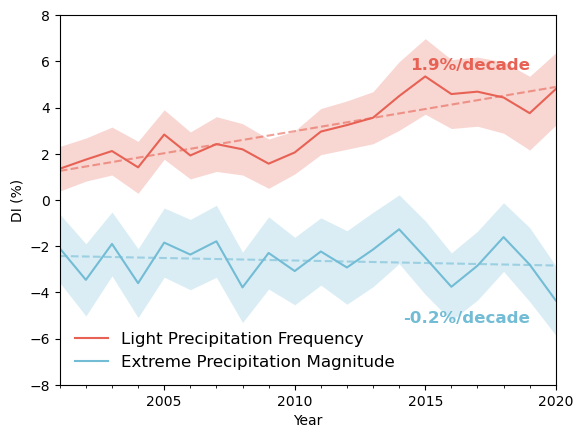

In [10]:
c_light_asc = np.array([231, 98, 84]) / 255
c_extreme_asc = np.array([114, 188, 213]) / 255
def compute_median_ci(data, confidence=0.95):
    n = len(data)
    median = np.median(data)
    stderr = stats.sem(data, ddof=1)
    margin_of_error = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
    return median - margin_of_error, median + margin_of_error
def plot_trend(ax):
    dict_df_colour = {
        "light": [df_di["1 to 5mm"], c_light_asc, "Light Precipitation Frequency"],
        "extreme": [df_di["RX30min"], c_extreme_asc, "Extreme Precipitation Magnitude"],
    }
    for type, (df_type, c_type, lbl_type) in dict_df_colour.items():
        # calculate the confidence intervals
        ci_low, ci_up = [], []
        for col in df_type.columns:
            low, up = compute_median_ci(df_type[col].dropna())
            ci_low.append(low)
            ci_up.append(up)
        ci_low = pd.Series(ci_low, index=df_type.columns)
        ci_up = pd.Series(ci_up, index=df_type.columns)

        ser_median = df_type.median() * 100
        # calculate the trend of median
        slope, intercept = np.polyfit(ser_median.index.year, ser_median, 1)
        ser_trend = pd.Series(
            slope * ser_median.index.year + intercept, index=ser_median.index
        ).rename(None)

        # Plot the median
        ax1 = ser_median.plot(color=c_type, label=lbl_type, ylabel=r"DI (%)")
        # fill with condidence interval
        _ = ax.fill_between(
            ser_median.index,
            ci_low * 100,
            ci_up * 100,
            color=c_type,
            alpha=0.26,
            lw=0,
        )

        # Plot the trend
        _ = ser_trend.plot(ax=ax, linestyle="--", color=c_type, alpha=0.6)

        # Plot the trend text
        i_pos = -2
        ser_quantile = (
            df_type.quantile(0.55, axis=0).T * 100
            if type == "light"
            else df_type.quantile(0.45, axis=0).T * 100
        )
        _ = ax.text(
            ser_median.index[i_pos],
            ser_quantile.iloc[i_pos],
            f"{slope*10:.1f}%/decade",
            ha="right",
            va="bottom" if type == "light" else "top",
            color=c_type,
            fontweight="bold",
            fontsize=12,
        )
        
        
   
    ax.set_ylabel("DI (%)", color="k",fontsize=10,)
    ax.set_xlabel("Year", color="k",fontsize=10,)
    ax.set_ylim(-8,8)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.xaxis.set_tick_params(labelsize=10)
    ax.legend(frameon = False, loc = "lower left",fontsize=12,)
    return ax


fig, ax = plt.subplots()
ax = plot_trend(ax)

# Overall DI across precipitation indices

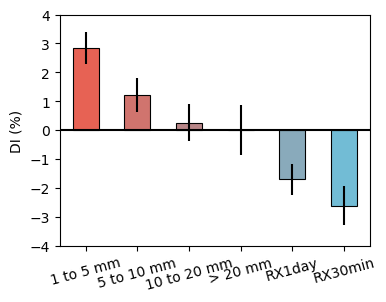

In [13]:
# Define two colours in RGB format
c_light_asc = np.array([231, 98, 84]) / 255
c_extreme_asc = np.array([114, 188, 213]) / 255

# Blend the colours with different blend factors
blend_factors = np.linspace(0, 1, 6)
blended_colors = [blend_colors(c_light_asc, c_extreme_asc, bf) for bf in blend_factors]



df_di_median = df_di.stack("di", future_stack=True).median(axis=1).unstack("di").median() * 100
df_di_median = df_di_median.rename(
        {
            "1 to 5mm": "1 to 5 mm",
            "5 to 10mm": "5 to 10 mm",
            "10 to 20mm": "10 to 20 mm",
            "> 20mm": "> 20 mm",

        })
#calculate the error bar by using the 95% confident interval
def compute_median_ci(data, confidence=0.95):
    n = len(data)
    median = np.median(data)
    stderr = stats.sem(data, ddof=1)
    margin_of_error = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
    return median - margin_of_error, median + margin_of_error
df_di_bar = df_di.stack("di", future_stack=True)
error_dict = {
    'di': [],
    'ci_low': [],
    'ci_up': []
}

for di_key, group in df_di_bar.groupby('di',sort=False):
    data = group.stack()
    data.fillna(-9999)
    data.replace([np.inf, -np.inf], -9999, inplace=True)
    ci_low, ci_up = compute_median_ci(data[data!=-9999])
    error_dict['di'].append(di_key)
    error_dict['ci_low'].append(ci_low)
    error_dict['ci_up'].append(ci_up)
error_dict = pd.DataFrame(error_dict)

def plot_total_bar(ax):
    ax = (df_di_median
    .plot(
        kind="bar",
        color=blended_colors,
        edgecolor="black",
        linewidth=0.8,
        xlabel="",fontsize=10,
        ylabel="DI (%)",
        rot=15,
        yerr=[(y - x)*100 for x, y in zip(error_dict["ci_low"], error_dict["ci_up"])],
        )
    )
    ax.set_ylim(-4,4)
    ax.set_ylabel("DI (%)", color="k",fontsize=10,)
    # ax.set_xlabel(fontsize=13,)
    ax.axhline(y=0, color="black", linestyle="-", linewidth=1.5)
    return ax
fig ,ax = plt.subplots(figsize = (4,3))
ax = plot_total_bar(ax)
fig.savefig("total_bar.pdf", dpi=300, bbox_inches="tight")